Initial Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [21]:
# Define hyperparameters
tl_hyperparameters = {
    'lr': {'penalty': 'l2', 'C': 0.01},
    'rf': {'n_estimators': 100, 'max_depth': 5}
}

xgb_hyperparameters = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'lambda': 1,
    'alpha': 0
}

In [3]:
df = pd.read_csv("Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


**Recency**: Months since last purchase.\
**History_Segment**: Categorization of dollars spent in the past year.\
**History**: Actual dollar value spent in the past year.\
**Mens**: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.\
**Womens**: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.\
**Zip_Code**: Classifies zip code as Urban, Suburban, or Rural.\
**Newbie**: 1/0 indicator, 1 = New customer in the past twelve months.\
**Channel**: Describes the channels the customer purchased from in the past year.

**Segment**\
Mens E-Mail\
Womens E-Mail\
No E-Mail

**Visit**: 1/0 indicator, 1 = Customer visited website in the following two weeks.\
**Conversion**: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.\
**Spend**: Actual dollars spent in the following two weeks.

In [4]:
# Drop the 'history_segment' column
df.drop(columns=['history_segment'], inplace=True)

In [5]:
df.head()

,recency,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [6]:
# Data preprocessing pipeline
numeric_features = ['recency', 'history']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['zip_code', 'channel', 'segment']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [7]:
# Split data into train and test sets
X = df.drop(['conversion', 'spend'], axis=1)
y_conv = df['conversion']
y_spend = df['spend']

X_train, X_test, y_conv_train, y_conv_test, y_spend_train, y_spend_test = train_test_split(
    X, y_conv, y_spend, test_size=0.2, random_state=42)

In [8]:
# Convert y_spend_train to binary labels
y_spend_train_binary = (y_spend_train > 0).astype(int)

In [22]:
# T-Learner for uplift modeling
learner_conversion = LogisticRegression(**tl_hyperparameters['lr'])
learner_spend = RandomForestClassifier(**tl_hyperparameters['rf'])

learner_conversion.fit(preprocessor.fit_transform(X_train), y_conv_train)
learner_spend.fit(preprocessor.fit_transform(X_train), y_spend_train_binary)

conversion_proba = learner_conversion.predict_proba(preprocessor.transform(X_test))[:, 1]
spend_proba = learner_spend.predict_proba(preprocessor.transform(X_test))[:, 1]

uplift_score = conversion_proba - spend_proba
uplift_auc = roc_auc_score(y_conv_test, uplift_score)
print(f"T-Learner Uplift AUC: {uplift_auc}")

T-Learner Uplift AUC: 0.4423032818418561


In [23]:
learner_conversion_xgb = xgb.XGBClassifier(**xgb_hyperparameters)
learner_conversion_xgb.fit(preprocessor.fit_transform(X_train), y_conv_train)
conversion_proba_xgb = learner_conversion_xgb.predict_proba(preprocessor.transform(X_test))[:, 1]


In [24]:
uplift_score_xgb = conversion_proba_xgb - spend_proba
uplift_auc_xgb = roc_auc_score(y_conv_test, uplift_score_xgb)
print(f"XGBoost Uplift AUC: {uplift_auc_xgb}")


XGBoost Uplift AUC: 0.48442123875473486


In [12]:
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'eval_metric': ['auc']
}
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic'),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [13]:
grid_search.fit(preprocessor.fit_transform(X_train), y_conv_train)
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [14]:
conversion_proba_optimized = best_xgb.predict_proba(preprocessor.transform(X_test))[:, 1]
uplift_score_optimized = conversion_proba_optimized - spend_proba
uplift_auc_optimized = roc_auc_score(y_conv_test, uplift_score_optimized)
print(f"Optimized XGBoost Uplift AUC: {uplift_auc_optimized}")


Optimized XGBoost Uplift AUC: 0.4938758310645518


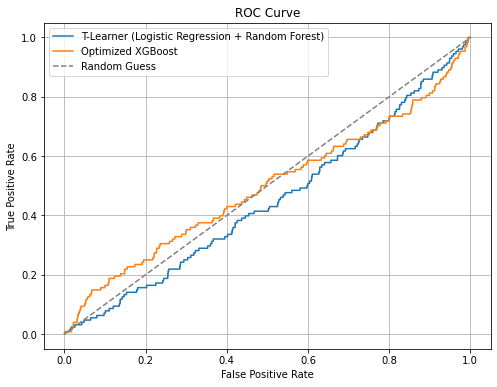

In [15]:
# Compute ROC curve for each model
fpr_lr_rf, tpr_lr_rf, _ = roc_curve(y_conv_test, uplift_score)
fpr_xgb, tpr_xgb, _ = roc_curve(y_conv_test, uplift_score_optimized)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_rf, tpr_lr_rf, label='T-Learner (Logistic Regression + Random Forest)')
plt.plot(fpr_xgb, tpr_xgb, label='Optimized XGBoost')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

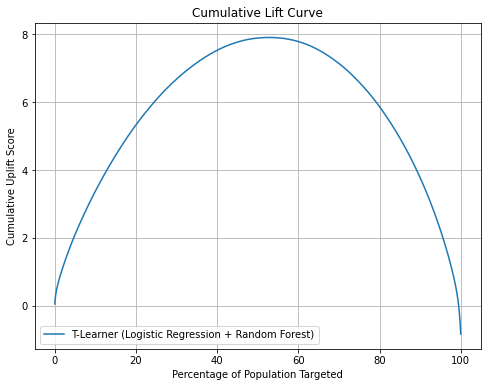

In [16]:
# Sort uplift scores to plot lift curve
sorted_indices = np.argsort(uplift_score)[::-1]
sorted_uplift = uplift_score[sorted_indices]

# Calculate cumulative percentage of individuals targeted
cumulative_population = np.arange(1, len(y_conv_test) + 1) / len(y_conv_test) * 100

# Plot lift curve
plt.figure(figsize=(8, 6))
plt.plot(cumulative_population, sorted_uplift.cumsum(), label='T-Learner (Logistic Regression + Random Forest)')
plt.xlabel('Percentage of Population Targeted')
plt.ylabel('Cumulative Uplift Score')
plt.title('Cumulative Lift Curve')
plt.legend()
plt.grid(True)
plt.show()


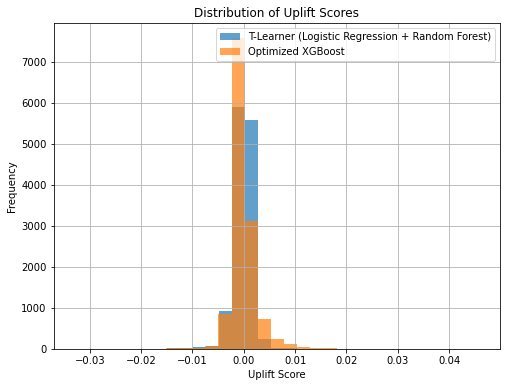

In [17]:
# Plot distribution of uplift scores
plt.figure(figsize=(8, 6))
plt.hist(uplift_score, bins=30, alpha=0.7, label='T-Learner (Logistic Regression + Random Forest)')
plt.hist(uplift_score_optimized, bins=30, alpha=0.7, label='Optimized XGBoost')
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Distribution of Uplift Scores')
plt.legend()
plt.grid(True)
plt.show()
